## 0.1) imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from colorama import Fore, Style
from dateutil.parser import parse
from typing import Dict, List, Tuple, Sequence
from datetime import datetime

from power.params import *
from power.ml_ops.data import *
from power.ml_ops.model import *
from power.ml_ops.registry import load_model, save_model, save_results
from power.ml_ops.cross_val import get_X_y_seq, get_X_y_seq_pv
from power.interface.main import pred

from power.utils import plot_loss_mae

import requests

In [21]:
#### Load saved sequences
X = np.load('X_train.npy')
y = np.load('y_train.npy')

X_full = np.load('X_train_full.npy')
y_full = np.load('y_train_full.npy')

## Get all data
data_pv_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_PV_processed = pd.read_csv(data_pv_processed_cache_path)

data_forecast_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_weather_forecast.csv")
data_forecast_processed = pd.read_csv(data_forecast_processed_cache_path)

data_PV_processed.utc_time = pd.to_datetime(data_PV_processed.utc_time,utc=True)
stats_df = get_stats_table(data_PV_processed, capacity=False)
pred_df = pred(input_pred='2022-07-06 12:00:00')

/home/jerome-roeser/code/jerome-roeser/11-Personal-Projects/git_repos/advanced-power-forecast/power/ml_ops/data.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_df['hour_of_year'] = years_df.utc_time.\



⭐️ Use case: predict

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-14 10:47:20.478688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 10:47:20.482926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 10:47:20.485437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-14 10:47:20.994062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 10:47:20.998696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 10:47:21.002316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 601ms/step
0     0.019183
1     0.019107
2     0.012188
3     0.014576
4     0.053692
5     0.134407
6     0.264830
7     0.398736
8     0.499018
9     0.575907
10    0.603619
11    0.588778
12    0.534362
13    0.473144
14    0.380129
15    0.258210
16    0.145263
17    0.068404
18    0.025287
19    0.000505
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: pred, dtype: float64

✅ prediction done:  [[ 1.9183181e-02  1.9107237e-02  1.2187872e-02  1.4576368e-02
   5.3691994e-02  1.3440683e-01  2.6483023e-01  3.9873564e-01
   4.9901825e-01  5.7590735e-01  6.0361862e-01  5.8877766e-01
   5.3436166e-01  4.7314394e-01  3.8012919e-01  2.5821024e-01
   1.4526340e-01  6.8403728e-02  2.5287062e-02  5.0473213e-04
  -1.2782320e-02 -1.7420694e-02 -1.5553609e-02 -1.6664773e-02]] (1, 24) 



# 1) Train Function

In [3]:
def train(
        min_date = '2017-10-07 00:00:00',
        max_date = '2019-12-31 23:00:00',
        split_ratio: float = 0.02, # 0.02 represents ~ 1 month of validation data on a 2009-2015 train set
        learning_rate=0.02,
        batch_size = 32,
        patience = 5,
        forecast_features = False
    ) -> float:

    """
    - Download processed data from your BQ table (or from cache if it exists)
    - Train on the preprocessed dataset (which should be ordered by date)
    - Store training results and model weights

    Return val_mae as a float
    """

    print(Fore.MAGENTA + "\n⭐️ Use case: train" + Style.RESET_ALL)
    print(Fore.BLUE + "\nLoading preprocessed validation data..." + Style.RESET_ALL)


    # --First-- Load processed PV data using `get_data_with_cache` in chronological order
    query_pv = f"""
        SELECT *
        FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
        ORDER BY utc_time
    """

    data_processed_pv_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
    data_processed_pv = get_data_with_cache(
        gcp_project=GCP_PROJECT,
        query=query_pv,
        cache_path=data_processed_pv_cache_path,
        data_has_header=True
    )
    # the processed PV data from bq needs to be converted to datetime object
    data_processed_pv.utc_time = pd.to_datetime(data_processed_pv.utc_time,utc=True)

    if data_processed_pv.shape[0] < 240:
        print("❌ Not enough processed data retrieved to train on")
        return None

    # Split the data into training and testing sets
    train_pv = data_processed_pv[(data_processed_pv['utc_time'] > min_date) \
                                 & (data_processed_pv['utc_time'] < max_date)]


    if forecast_features:
    # --Second-- Load processed Weather Forecast data in chronological order
        query_forecast = f"""
            SELECT *
            FROM {GCP_PROJECT}.{BQ_DATASET}.processed_weather_forecast
            ORDER BY forecast_dt_unixtime, slice_dt_unixtime
        """

        data_processed_forecast_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_weather_forecast.csv")
        data_processed_forecast = get_data_with_cache(
            gcp_project=GCP_PROJECT,
            query=query_forecast,
            cache_path=data_processed_forecast_cache_path,
            data_has_header=True
        )



        if data_processed_forecast.shape[0] < 240:
            print("❌ Not enough processed data retrieved to train on")
            return None

        # Split the data into training and testing sets
        train_forecast = data_processed_forecast

        X_train, y_train = get_X_y_seq(train_pv,
                                    train_forecast,
                                    number_of_sequences=10_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)

    else:
        X_train, y_train = get_X_y_seq_pv(train_pv,
                                    number_of_sequences=10_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)

    # Train model using `model.py`
    model = load_model()

    if model is None:
        model = initialize_model(X_train, y_train, n_unit=24)


    model = compile_model(model, learning_rate=learning_rate)
    model, history = train_model(model,
                                X_train,
                                y_train,
                                validation_split = 0.3,
                                batch_size = 32,
                                epochs = 50
                                )

    val_mae = np.min(history.history['val_mae'])

    params = dict(
        context="train",
        training_set_size=f'Training data from {min_date} to {max_date}',
        row_count=len(X_train),
    )

    # Save results on the hard drive using taxifare.ml_logic.registry
    save_results(params=params, metrics=dict(mae=val_mae))

    # Save model weight on the hard drive (and optionally on GCS too!)
    save_model(model=model)

    print("✅ train() done \n")

    return X_train , y_train, model, history

In [4]:
# X_train , y_train, model, history = train(forecast_features= False)
# X_train.shape, y_train.shape

In [5]:
# np.save(file= 'X_train', arr= X_train)
# np.save(file= 'y_train', arr= y_train)

X = np.load('X_train.npy')
y = np.load('y_train.npy')

In [6]:
X.shape, y.shape

((10000, 48, 1), (10000, 24, 1))

In [7]:
# X_train_full , y_train_full = train(forecast_features= True)
# X_train_full.shape, y_train_full.shape

In [8]:
# np.save(file= 'X_train_full', arr= X_train_full)
# np.save(file= 'y_train_full', arr= y_train_full)

X_full = np.load('X_train_full.npy')
y_full = np.load('y_train_full.npy')

In [9]:
X_full.shape, y_full.shape

((10000, 48, 5), (10000, 24, 1))

# 2) Model Evaluation 

## 2.1) historical PV production data training

2024-11-14 07:09:29.175811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 07:09:29.182054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 07:09:29.185209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

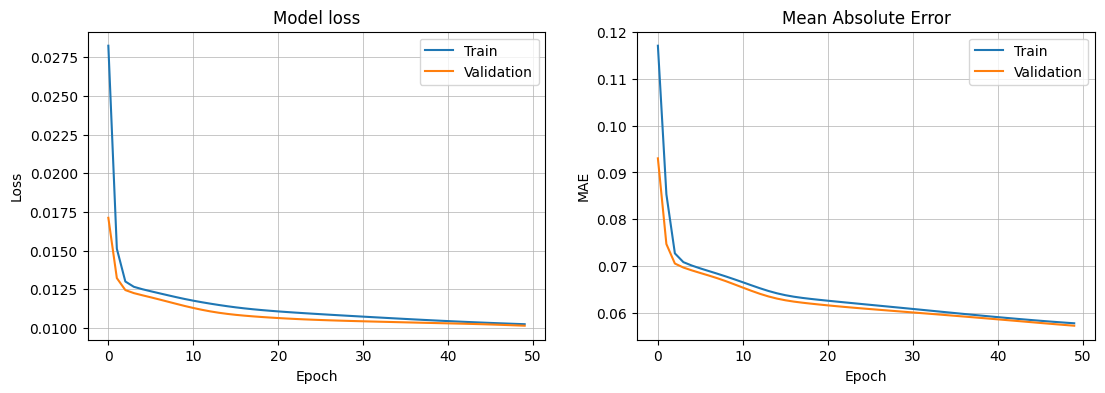

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 1)            3         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 24)                600       
                                                                 
Total params: 3,099
Trainable params: 3,096
Non-trainable params: 3
_________________________________________________________________


In [8]:
model = initialize_model(X, y)
model = compile_model(model, learning_rate= 1e-3)
model, history = train_model(model, X, y)
plot_loss_mae(history)
model.summary()

## 2.2) historical PV production + historical weather-forecast data

2024-11-14 07:31:42.275560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 07:31:42.284089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 07:31:42.287344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

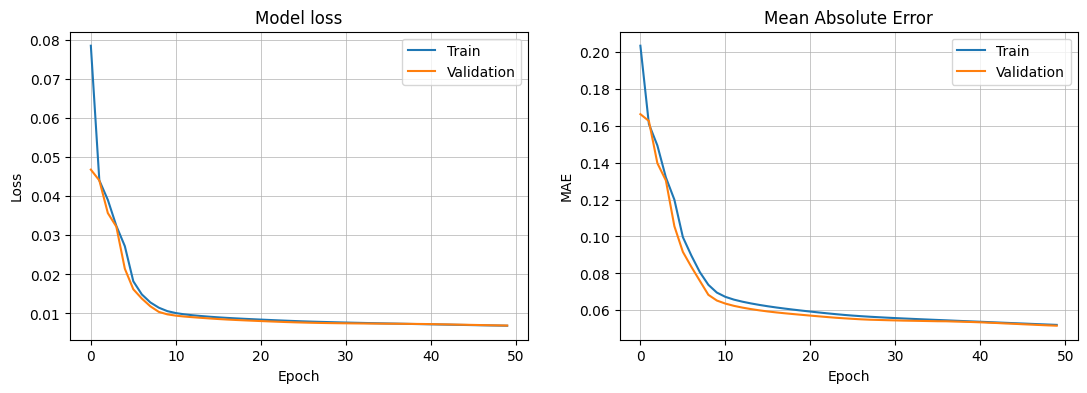

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 48, 5)            11        
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 24)                2880      
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
Total params: 3,491
Trainable params: 3,480
Non-trainable params: 11
_________________________________________________________________


In [9]:
model = initialize_model(X_full, y_full)
model = compile_model(model, learning_rate=1e-3)
model, history = train_model(model, X_full, y_full)
plot_loss_mae(history)
model.summary()

In [74]:
def get_baseline_data(input_date: str) -> np.array:
    """
    Return a numpy array for 3-days (before and ahead of sell date) statistics
    of PV power prodcution for a sell date.

    Input:
    the sell date: 'YYYY-MM-DD' e.g. '2022-07-06'

    Output:
    numpy array of shape (72,11) for 72 hours of data with 11 features
    Features:
        {0:'utc_time', 1:'local_time', 2:'electricity', 3:'hour_of_year',
        4:'mean', 5:'median', 6:'std', 7:'skew', 8'min', 9'max', 10:'count'}
    """
    # collect input for postprocess
    data_pv_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
    data_PV_processed = pd.read_csv(data_pv_processed_cache_path)

    data_PV_processed.utc_time = pd.to_datetime(data_PV_processed.utc_time,utc=True)
    stats_df = get_stats_table(data_PV_processed, capacity=False)

    # get plot_df
    plot_df = postprocess(input_date, data_PV_processed, stats_df)

    # Send as dict from backend to frontend; NaNs have to be replaced
    plot_df = plot_df.fillna(0.0)
    # plot_dict = plot_df.to_dict()

    return plot_df


baseline_df = get_baseline_data(input_date= '2022-01-01')
baseline_array = baseline_df.to_numpy()
baseline_df

/home/jerome-roeser/code/jerome-roeser/11-Personal-Projects/git_repos/advanced-power-forecast/power/ml_ops/data.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_df['hour_of_year'] = years_df.utc_time.\


,utc_time,local_time,electricity,hour_of_year,mean,median,std,skew,min,max,count
0,2021-12-31 00:00:00+00:00,2021-12-31 00:00:00+00:00,0.0,123100,0.0,0.0,0.0,0.0,0.0,0.0,40
1,2021-12-31 01:00:00+00:00,2021-12-31 01:00:00+00:00,0.0,123101,0.0,0.0,0.0,0.0,0.0,0.0,40
2,2021-12-31 02:00:00+00:00,2021-12-31 02:00:00+00:00,0.0,123102,0.0,0.0,0.0,0.0,0.0,0.0,40
3,2021-12-31 03:00:00+00:00,2021-12-31 03:00:00+00:00,0.0,123103,0.0,0.0,0.0,0.0,0.0,0.0,40
4,2021-12-31 04:00:00+00:00,2021-12-31 04:00:00+00:00,0.0,123104,0.0,0.0,0.0,0.0,0.0,0.0,40
...,...,...,...,...,...,...,...,...,...,...,...
67,2022-01-02 19:00:00+00:00,2022-01-02 19:00:00+00:00,0.0,010219,0.0,0.0,0.0,0.0,0.0,0.0,40
68,2022-01-02 20:00:00+00:00,2022-01-02 20:00:00+00:00,0.0,010220,0.0,0.0,0.0,0.0,0.0,0.0,40
69,2022-01-02 21:00:00+00:00,2022-01-02 21:00:00+00:00,0.0,010221,0.0,0.0,0.0,0.0,0.0,0.0,40
70,2022-01-02 22:00:00+00:00,2022-01-02 22:00:00+00:00,0.0,010222,0.0,0.0,0.0,0.0,0.0,0.0,40


In [ ]:
baseline_array[-24:,4] # mean of day-ahead for keras lamdbda layer

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003425, 0.04835,
       0.11347499999999999, 0.171925, 0.18860000000000002, 0.1673,
       0.10022500000000001, 0.019725, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0], dtype=object)

In [77]:
baseline_array[:24, 2] # day before sell for keras lambda layer

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.028, 0.056, 0.056,
       0.023, 0.016, 0.011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0], dtype=object)

# 3) API Calls

In [32]:
### API call ==================================================================
#base_url = "http://127.0.0.1:8000"
base_url = "https://power-v2-pdymu2v2na-ew.a.run.app"
#------------------------------------------------------------------------------

def call_visu(today_date):

    params_visu ={
        'input_date': today_date,   # '2000-05-15' (dt.date())
        'power_source': 'pv',
        'capacity': 'true'
        }

    endpoint_visu = "/visualisation"
    url_visu = f"{base_url}{endpoint_visu}"
    response_visu = requests.get(url_visu, params_visu).json()

    plot_df = pd.DataFrame.from_dict(response_visu)
    plot_df.utc_time = pd.to_datetime(plot_df.utc_time,utc=True)

    return plot_df

In [33]:
plot_df = call_visu('2022-12-10')

In [35]:
plot_df.columns

Index(['utc_time', 'local_time', 'electricity', 'cap_fac', 'hour_of_year',
       'mean', 'median', 'std', 'skew', 'min', 'max', 'count', 'pred'],
      dtype='object')

<Axes: >

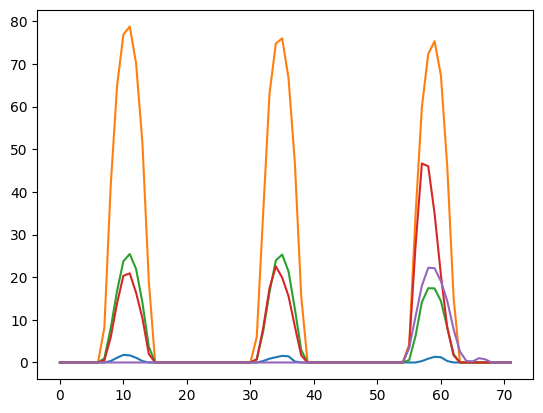

In [36]:
plot_df['min'].plot()
plot_df['max'].plot()
plot_df['mean'].plot()
plot_df['cap_fac'].plot()
plot_df['pred'].plot()

In [41]:
def visualisation(input_date: str, power_source='pv', capacity='false') -> None:
  """
  input_date corresponds to "today"
  """

  # collect input for postprocess
  pred_df = pred( f"{input_date} 12:00:00")
  data_pv_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
  preprocessed_df = pd.read_csv(data_pv_processed_cache_path)
  preprocessed_df.utc_time = pd.to_datetime(preprocessed_df.utc_time,utc=True)

  if capacity == 'true':
    print('Capacity!')
    preprocessed_df['cap_fac'] = preprocessed_df.electricity / 0.9 * 100 # 0.9 is max value for pv
    stats_df = get_stats_table(preprocessed_df, capacity=True)
    pred_df.pred = pred_df.pred / 0.9 * 100
  else:
    print('Electricity!')
    stats_df = get_stats_table(preprocessed_df, capacity=False)

  # get plot_df
  plot_df = postprocess(input_date, preprocessed_df, stats_df, pred_df)

  # Send as dict from backend to frontend; NaNs have to be replaced
  plot_df = plot_df.fillna(0.0)
  plot_dict = plot_df.to_dict()

  return plot_dict

plot_dict = visualisation('2022-07-06')


⭐️ Use case: predict

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-14 11:01:56.656511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 11:01:56.659895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 11:01:56.661870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-14 11:01:57.176097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 11:01:57.179759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 11:01:57.183963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 604ms/step
0     0.019183
1     0.019107
2     0.012188
3     0.014576
4     0.053692
5     0.134407
6     0.264830
7     0.398736
8     0.499018
9     0.575907
10    0.603619
11    0.588778
12    0.534362
13    0.473144
14    0.380129
15    0.258210
16    0.145263
17    0.068404
18    0.025287
19    0.000505
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: pred, dtype: float64

✅ prediction done:  [[ 1.9183181e-02  1.9107237e-02  1.2187872e-02  1.4576368e-02
   5.3691994e-02  1.3440683e-01  2.6483023e-01  3.9873564e-01
   4.9901825e-01  5.7590735e-01  6.0361862e-01  5.8877766e-01
   5.3436166e-01  4.7314394e-01  3.8012919e-01  2.5821024e-01
   1.4526340e-01  6.8403728e-02  2.5287062e-02  5.0473213e-04
  -1.2782320e-02 -1.7420694e-02 -1.5553609e-02 -1.6664773e-02]] (1, 24) 

Electricity!


/home/jerome-roeser/code/jerome-roeser/11-Personal-Projects/git_repos/advanced-power-forecast/power/ml_ops/data.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_df['hour_of_year'] = years_df.utc_time.\


In [ ]:
import streamlit as st
import requests

import numpy as np
import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as dates


# used in the plots
today_date = st.session_state['today']
plot_df = st.session_state['plot_df']
#------------------------------------------------------------------------------

### capacity

# time variables
today_dt = pd.Timestamp(today_date, tz='UTC')
time = plot_df.utc_time.values

sep_future = today_dt + pd.Timedelta(days=1)
sep_past = today_dt
sep_order = today_dt + pd.Timedelta(hours=12)

# plot
fig, ax = plt.subplots(figsize=(15,5))

ax.axvline(sep_past, color='k', linewidth=0.7)
ax.axvline(sep_future, color='k', linewidth=0.7)
ax.vlines(sep_order, ymin=0, ymax=100, color='k', linewidth=0.7, linestyle='--')

# stats
alpha_stats = 0.2
ax.step(time, plot_df['min'].values, where='pre',
        color='k', linestyle=':', alpha=alpha_stats, label='min')
ax.step(time, plot_df['max'].values, where='pre',
        color='k', linestyle=':', alpha=alpha_stats, label='max')
ax.step(time, plot_df['mean'].values, where='pre',
        color='k', linestyle='-', alpha=alpha_stats, label='mean')

lower_bound = plot_df['mean'].values - 1 * plot_df['std'].values
upper_bound = plot_df['mean'].values + 1 * plot_df['std'].values
ax.fill_between(time, lower_bound, upper_bound, step='pre',
                color='gray',
                alpha=alpha_stats,
                label='std')

# true current production data
current = 37 # current production data
ax.step(time[:current], plot_df.cap_fac.values[:current], where='pre',
        color='orange', linewidth=4, label='true')

# prediction day ahead data
hori = -24
ax.step(time[hori:], plot_df.pred.values[hori:], where='pre',
        color='orange', linewidth=4, linestyle=':', label='pred')

###
if show_true == 'Yes':
    ax.step(time[-36:], plot_df.cap_fac.values[-36:], where='pre',
         color='orange', linewidth=4, linestyle='-', alpha=0.4)
    st.sidebar.write('')
else:
    st.sidebar.write('')

# date ticks
ax.xaxis.set_major_locator(dates.HourLocator(byhour=range(24), interval=12, tz='UTC'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M %d/%m/%Y'))

ax.set_xlim(today_dt - pd.Timedelta(days=1), today_dt + pd.Timedelta(days=2))
ax.set_ylim(0,120.0)
ax.set_xlabel('Time')
ax.set_ylabel('Capacity factor in %')

ax.annotate('Day-Ahead',(0.77,0.9), xycoords='subfigure fraction')
ax.annotate('Today',(0.48,0.9), xycoords='subfigure fraction')
ax.annotate('Day-Behind',(0.15,0.9), xycoords='subfigure fraction')
ax.annotate('Order book closed',(0.51,0.77), xycoords='subfigure fraction')
#ax.set_title(f"Day Ahead prediction for { sep_future.strftime('%d/%m/%Y') }")

ax.legend();